In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

import env
import wrangle

In [ ]:
df = wrangle.wrangle_zillow()
df.head()

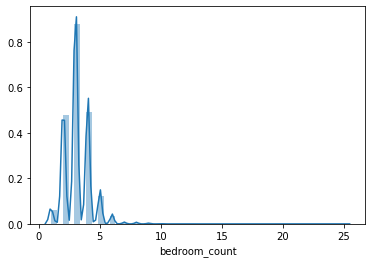

In [4]:
sns.distplot(df['bedroom_count'])


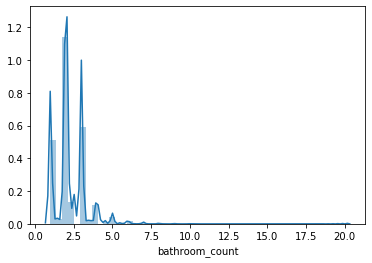

In [5]:
sns.distplot(df['bathroom_count'])

(0, 10000)

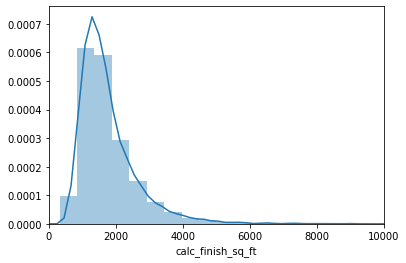

In [6]:
sns.distplot(df['calc_finish_sq_ft'])
plt.xlim(0,10000)

(0, 1000000)

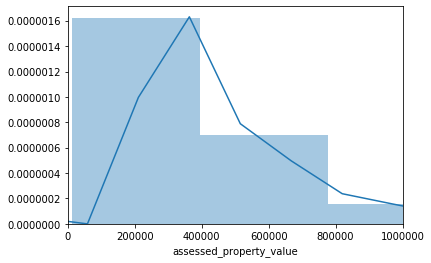

In [7]:
sns.distplot(df['assessed_property_value'])
plt.xlim(0,1_000_000)

In [12]:
# Dropping some columns for the split and scaling to create MVP, but 
# I'm going to create a new dataframe so I can retain the other columns on reference

mvp_df = df.drop(['property_id', 'tax_paid', 'tax_rate', 'county_code', 'county'], axis = 1)
mvp_df.head()

,bathroom_count,bedroom_count,calc_finish_sq_ft,assessed_property_value
0,2.0,4.0,1604.0,498347.0
1,3.0,3.0,2384.0,549917.0
2,2.0,3.0,1574.0,235272.0
3,2.0,2.0,1619.0,340000.0
4,3.0,3.0,1936.0,418146.0


In [13]:
## SPLIT AND SCALE ##
## SPLIT train_ratio of 0.8 and the seed of 123##
import split_scale

train, test = split_scale.split_my_data(mvp_df,train_ratio=.8,seed=123)


scaler, train_scaled, test_scaled = split_scale.standard_scaler(train,test)

X_train = train.drop(columns='assessed_property_value')
y_train = train[['assessed_property_value']]
X_test = test.drop(columns='assessed_property_value')
y_test = test[['assessed_property_value']]



In [14]:
## DATA EXPLORATION ###

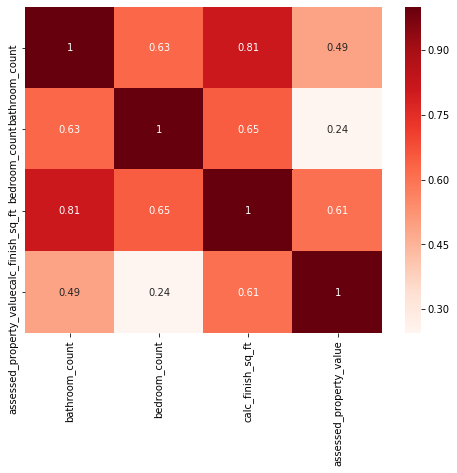

In [15]:
plt.figure(figsize=(8,6))
cor = train.corr()
sns.heatmap(cor,annot=True,cmap=plt.cm.Reds)
plt.show()

In [16]:
import statsmodels.api as sm

#OLS object to analyze features

ols_model = sm.OLS(y_train,X_train)
fit = ols_model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                   
============================================================================================
Dep. Variable:     assessed_property_value   R-squared (uncentered):                   0.618
Model:                                 OLS   Adj. R-squared (uncentered):              0.618
Method:                      Least Squares   F-statistic:                              8867.
Date:                     Thu, 17 Oct 2019   Prob (F-statistic):                        0.00
Time:                             21:20:24   Log-Likelihood:                     -2.3745e+05
No. Observations:                    16414   AIC:                                  4.749e+05
Df Residuals:                        16411   BIC:                                  4.749e+05
Df Model:                                3                                                  
Covariance Type:                 nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
bathroom_count     4.051e+04   6116.751      6.623      0.000    2.85e+04    5.25e+04
bedroom_count     -1.538e+05   3500.457    -43.943      0.000   -1.61e+05   -1.47e+05
calc_finish_sq_ft   473.7094      6.929     68.364      0.000     460.127     487.292
==============================================================================
Omnibus:                    25458.288   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         30533989.059
Skew:                           9.525   Prob(JB):                         0.00
Kurtosis:                     213.435   Cond. No.                     3.55e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.55e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

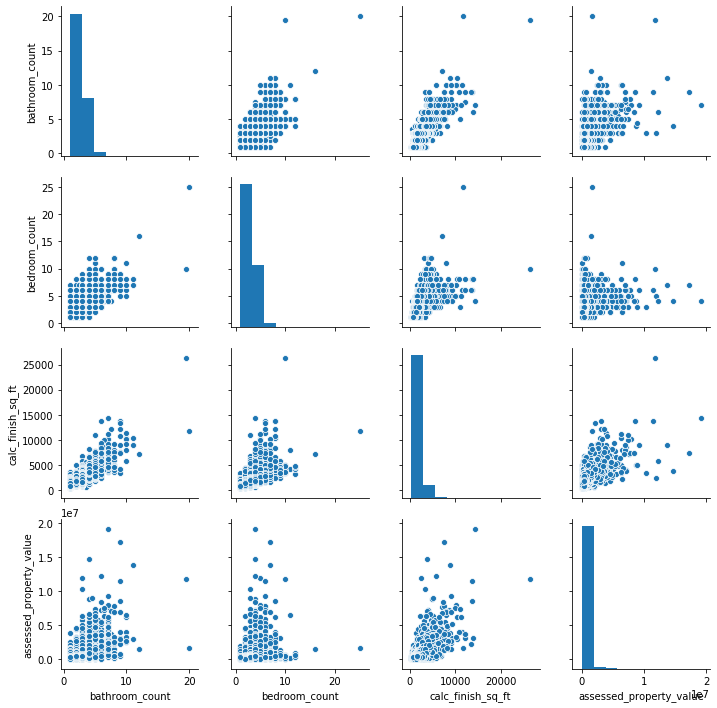

In [17]:
sns.pairplot(mvp_df)

(0, 10)

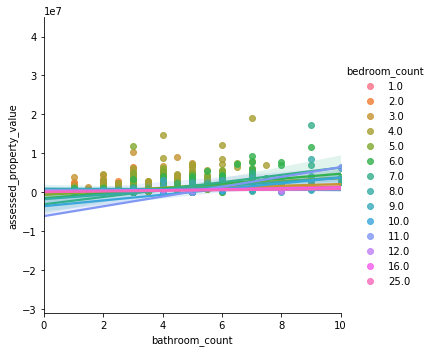

In [24]:
df_bedrooms = (mvp_df['bedroom_count'] < 5) & (mvp_df['assessed_property_value'] < 1000000)
g = sns.lmplot(x='bathroom_count',y='assessed_property_value',hue='bedroom_count',data=mvp_df)
plt.xlim(0,10)

In [25]:
## REGRESSION ##

import features
from sklearn.linear_model import LinearRegression
#pick model type, Linear Regression for the MVP baseline
lm1 = LinearRegression()

In [27]:
#fit and train model
lm1.fit(X_train,y_train)
lm1_y_intercept = lm1.intercept_
lm1_coefficients = lm1.coef_
print('{} = b + m1 * {} + m2 * {}'.format(y_train.columns[0], X_train.columns[0],X_train.columns[1]))
print('    y-intercept  (b): %.2f' % lm1_y_intercept)
print('    coefficient (m1): %.2f' % lm1_coefficients[0][0])
print('    coefficient (m2): %.2f' % lm1_coefficients[0][1])

assessed_property_value = b + m1 * bathroom_count + m2 * bedroom_count
    y-intercept  (b): -19188.64
    coefficient (m1): 42804.94
    coefficient (m2): -149112.41


In [28]:
#target prediction

y_pred_lm1 = lm1.predict(X_train)

In [29]:
mse_lm1 = mean_squared_error(y_train,y_pred_lm1)
print("linear model\n  mean squared error: {:.3}".format(mse_lm1)) 

r2_lm1 = r2_score(y_train,y_pred_lm1)
print('  {:.2%} of the variance in the house price can be explained by the number of bathrooms, number of bedrooms, and sq ft of house.'.format(r2_lm1))

linear model
  mean squared error: 2.15e+11
  41.11% of the variance in the house price can be explained by the number of bathrooms, number of bedrooms, and sq ft of house.


In [30]:
#establish baseline
from math import sqrt
y_pred_baseline = np.array([y_train.mean()[0]]*len(y_train))
MSE = mean_squared_error(y_train,y_pred_baseline)
SSE = MSE * len(y_train)
RMSE = sqrt(MSE)

evs = explained_variance_score(y_train,y_pred_baseline)